In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import imutils
import matplotlib.patches as patches
import pytesseract
import cv2

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from helpers.utils import plot_history, load_kaggle_A_Z, load_custom_dataset, plot_correct_incorrect
from custom_dataset_preprocess import scale_dataset, rgb2gray, shrink

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers

from helpers.sliding_window_utils import pyramid, sliding_window, detect_text, handwriting_detection

# Load Kaggle A-Z dataset

In [2]:
X, y = load_kaggle_A_Z("./kaggle_A-Z_dataset/A_Z Handwritten Data.csv")
sample_idx = 100000
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
print("Label sample:", alphabet[y[sample_idx]])

Label sample: L


In [3]:
X = scale_dataset(X)
X = X.reshape(-1, 28, 28, 1)
print(X.shape)
print(X.dtype)

(372450, 28, 28, 1)
float64


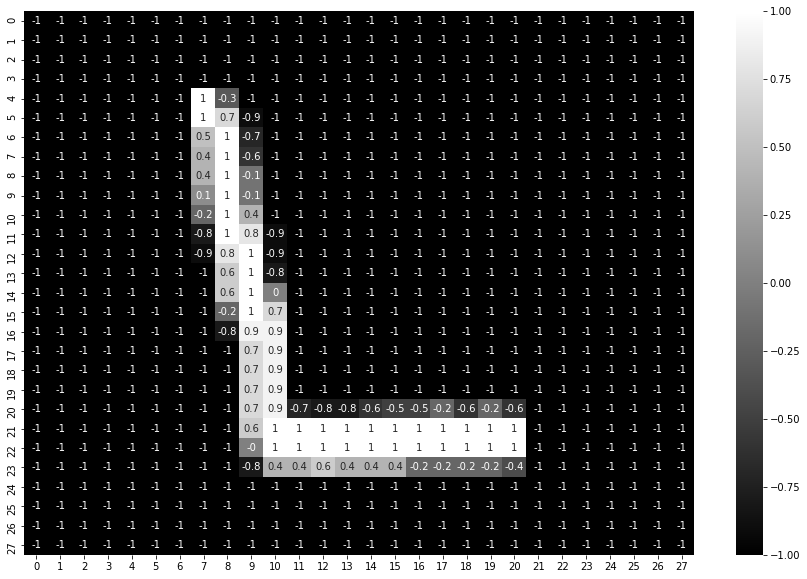

In [4]:
plt.figure(figsize=(15, 10))
sns.heatmap(np.round(X[sample_idx], 1).reshape(28, 28), cmap="gray", annot=True, fmt="g")
plt.show()

# Load custom dataset

In [5]:
X_transfer, y_transfer = load_custom_dataset("./preprocessed_dataset")

In [6]:
X_transfer = scale_dataset(X_transfer)
X_transfer = X_transfer.reshape(-1, 28, 28, 1)
print(X_transfer.shape)
print(X_transfer.dtype)

(260, 28, 28, 1)
float64


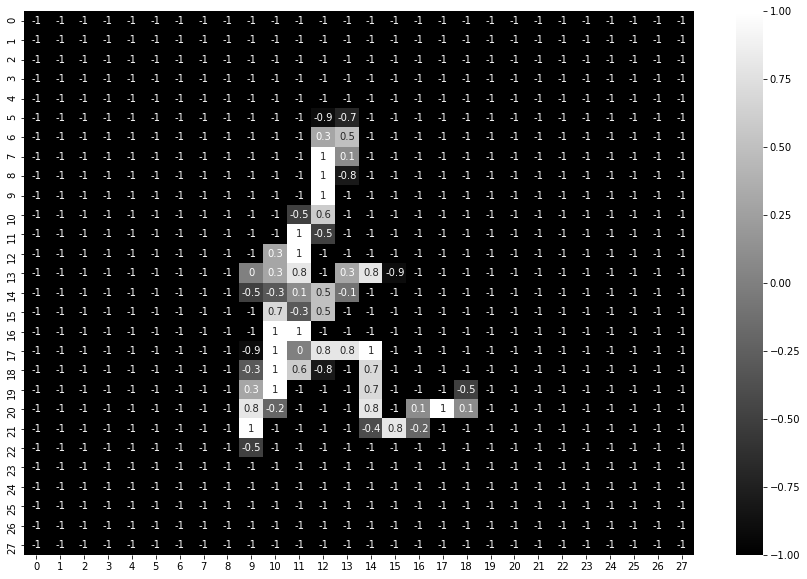

In [7]:
plt.figure(figsize=(15, 10))
sns.heatmap(np.round(X_transfer[100], 1).reshape(28, 28), cmap="gray", annot=True, fmt="g")
plt.show()

# Split dataset

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_train_transfer, X_valid_transfer, y_train_transfer, y_valid_transfer = train_test_split(X_transfer, y_transfer, test_size=0.4, random_state=0, stratify=y_transfer)

# Define Model

In [9]:
### MODEL 1 ###
# model = models.Sequential()
# model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(28, 28, 1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(26, activation='softmax'))


### MODEL 2 ###
# NUMFILTERS = 16
# FILTER = 3
# ACTIVATION = 'tanh'
# DROPOUT = 0.5

# model = models.Sequential([
#     layers.Conv2D(NUMFILTERS, (FILTER, FILTER), padding='same', activation=ACTIVATION, input_shape=(28, 28, 1)),
#     layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

#     layers.Conv2D(NUMFILTERS*2, (FILTER, FILTER), padding='same', activation=ACTIVATION),
#     layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

#     layers.Conv2D(NUMFILTERS*4, (FILTER, FILTER), padding='same', activation=ACTIVATION),
#     layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

#     layers.Conv2D(NUMFILTERS*8, (FILTER, FILTER), padding='same', activation=ACTIVATION),
#     layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

#     layers.Flatten(),
#     layers.Dropout(DROPOUT),
#     layers.Dense(26*6, activation=ACTIVATION),
#     layers.Dropout(DROPOUT),
#     layers.Dense(26*2, activation=ACTIVATION),
#     layers.Dropout(DROPOUT),
#     layers.Dense(26, activation='softmax'),
# ])

### MODEL 3 ###
model = models.Sequential([
    layers.Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = "relu", input_shape = (28,28,1), kernel_regularizer=regularizers.l2(0.0005)),
    layers.Conv2D(filters = 32, kernel_size = 5, strides = 1, use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Dropout(0.25),
    layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = "relu", kernel_regularizer=regularizers.l2(0.0005)),
    layers.Conv2D(filters = 64, kernel_size = 3, strides = 1, use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Dropout(0.25),
    layers.Flatten(),
    # — — — — — — — — — — — — — — — — #
    # Layer 6
    layers.Dense(units = 256, use_bias=False),
    # Layer 7
    layers.BatchNormalization(),
    # — — — — — — — — — — — — — — — — #
    layers.Activation("relu"),
    # — — — — — — — — — — — — — — — — #
    # Layer 8
    layers.Dense(units = 128, use_bias=False),
    # Layer 9
    layers.BatchNormalization(),
    # — — — — — — — — — — — — — — — — #
    layers.Activation("relu"),
    # — — — — — — — — — — — — — — — — #
    # Layer 10
    layers.Dense(units = 84, use_bias=False),
    # Layer 11
    layers.BatchNormalization(),
    # — — — — — — — — — — — — — — — — #
    layers.Activation("relu"),
    layers.Dropout(0.25),
    # — — — — — — — — — — — — — — — — #
    # Output
    layers.Dense(units = 26, activation = "softmax"),
    
], name="Base_CNN_Model")

In [10]:
model.summary()

Model: "Base_CNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 32)        25600     
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 20, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 20, 20, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)       

In [11]:
checkpoint_path = "model_checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [12]:
history = model.fit(X_train, y_train, epochs=30, 
                    validation_data=(X_valid, y_valid),
                    callbacks=[cp_callback])
model.save("./models/trained_CNN.h5")

Epoch 1/30
9312/9312 [==============================] - 51s 5ms/step - loss: 0.4146 - accuracy: 0.8940 - val_loss: 0.0757 - val_accuracy: 0.9833

Epoch 00001: saving model to model_checkpoints/cp.ckpt
Epoch 2/30
9312/9312 [==============================] - 50s 5ms/step - loss: 0.1151 - accuracy: 0.9735 - val_loss: 0.0684 - val_accuracy: 0.9855

Epoch 00002: saving model to model_checkpoints/cp.ckpt
Epoch 3/30
9312/9312 [==============================] - 50s 5ms/step - loss: 0.0968 - accuracy: 0.9782 - val_loss: 0.0552 - val_accuracy: 0.9882

Epoch 00003: saving model to model_checkpoints/cp.ckpt
Epoch 4/30
9312/9312 [==============================] - 48s 5ms/step - loss: 0.0855 - accuracy: 0.9808 - val_loss: 0.0594 - val_accuracy: 0.9879

Epoch 00004: saving model to model_checkpoints/cp.ckpt
Epoch 5/30
9312/9312 [==============================] - 49s 5ms/step - loss: 0.0789 - accuracy: 0.9825 - val_loss: 0.0669 - val_accuracy: 0.9854

Epoch 00005: saving model to model_checkpoints/cp.

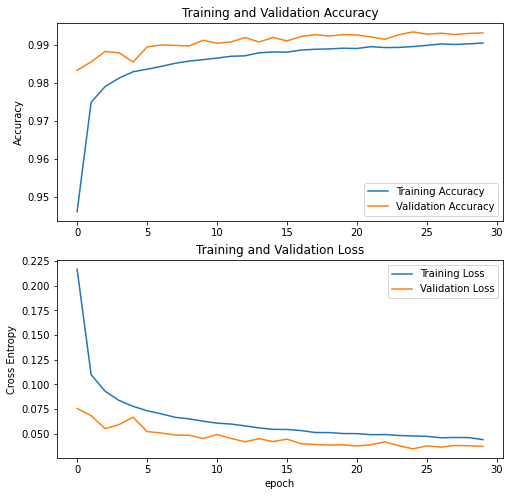

In [13]:
plot_history(history, "base_CNN_model")

# of correctly predicted samples: 73976
# of incorrectly predicted samples: 514


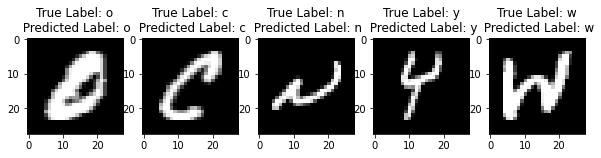

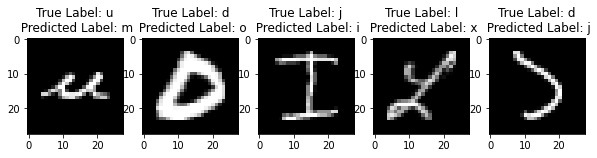

In [14]:
plot_correct_incorrect(X_valid, y_valid, model)

# Transfer Learning

In [15]:
model = tf.keras.models.load_model("./models/trained_CNN.h5")

model.trainable = True

freeze_at = 12

for layer in model.layers[:freeze_at]:
  layer.trainable =  False

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [16]:
epochs = 30
history = model.fit(X_transfer, y_transfer,
                    validation_data=(X_valid_transfer, y_valid_transfer),
                    epochs=epochs)
model.save("./models/transfer_model.h5")

Epoch 1/30
9/9 [==============================] - 1s 34ms/step - loss: 6.2151 - accuracy: 0.4045 - val_loss: 3.7644 - val_accuracy: 0.3750
Epoch 2/30
9/9 [==============================] - 0s 7ms/step - loss: 5.8291 - accuracy: 0.4431 - val_loss: 3.2377 - val_accuracy: 0.4519
Epoch 3/30
9/9 [==============================] - 0s 7ms/step - loss: 4.4617 - accuracy: 0.4730 - val_loss: 2.7568 - val_accuracy: 0.4519
Epoch 4/30
9/9 [==============================] - 0s 7ms/step - loss: 4.0099 - accuracy: 0.5228 - val_loss: 2.3586 - val_accuracy: 0.4904
Epoch 5/30
9/9 [==============================] - 0s 7ms/step - loss: 3.1949 - accuracy: 0.5254 - val_loss: 2.0205 - val_accuracy: 0.5673
Epoch 6/30
9/9 [==============================] - 0s 7ms/step - loss: 2.8097 - accuracy: 0.5282 - val_loss: 1.7537 - val_accuracy: 0.5962
Epoch 7/30
9/9 [==============================] - 0s 7ms/step - loss: 2.7230 - accuracy: 0.5281 - val_loss: 1.5074 - val_accuracy: 0.6442
Epoch 8/30
9/9 [=================

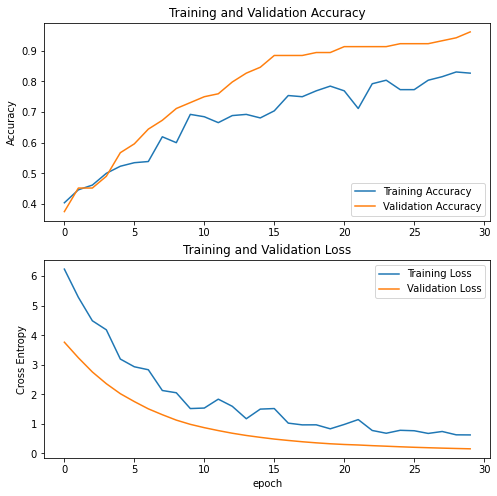

In [17]:
plot_history(history, "transfer_model")

# of correctly predicted samples: 100
# of incorrectly predicted samples: 4


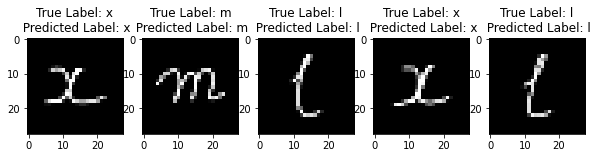

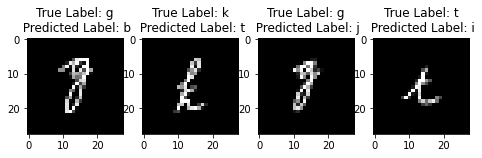

In [18]:
plot_correct_incorrect(X_valid_transfer, y_valid_transfer, model)

# Sliding window

In [19]:
model = tf.keras.models.load_model("./models/transfer_model.h5")
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

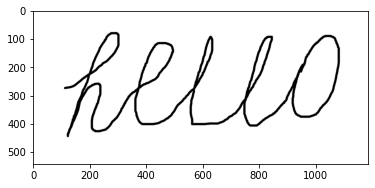

In [22]:
img = cv2.imread("./sample_images/hello1.png")
plt.imshow(img, cmap="gray")

(542, 1186)
int64


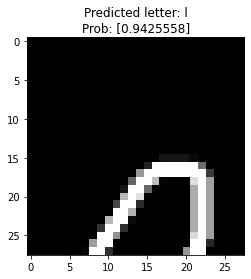

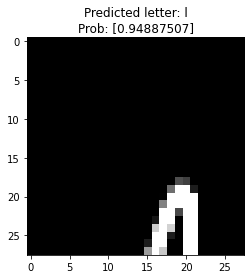

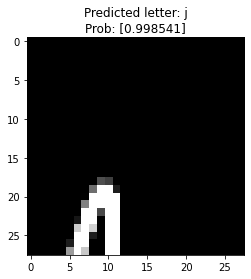

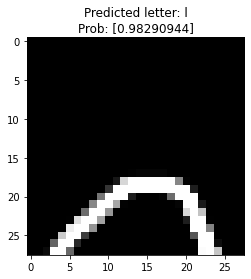

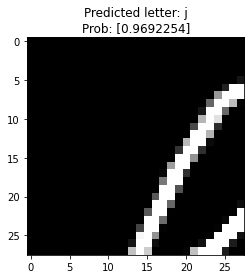

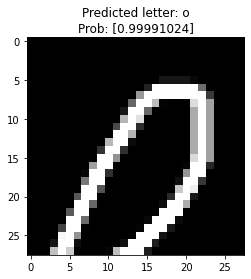

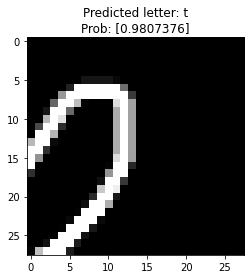

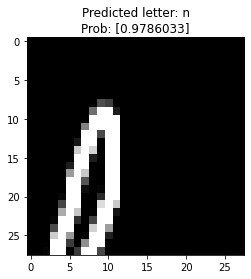

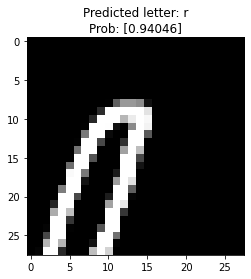

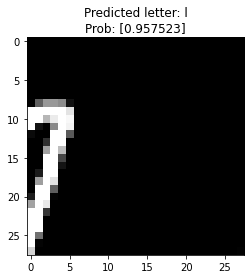

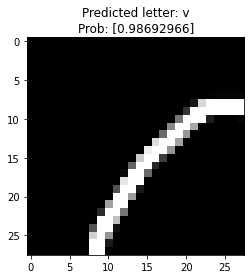

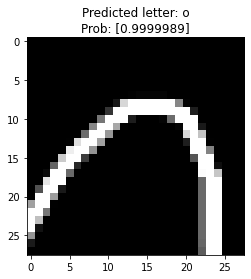

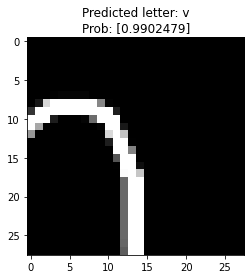

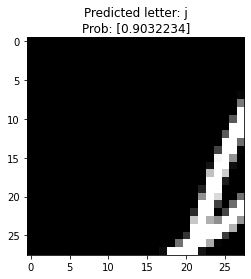

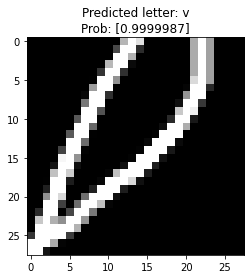

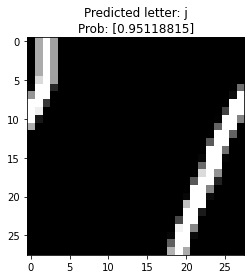

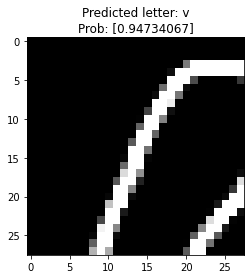

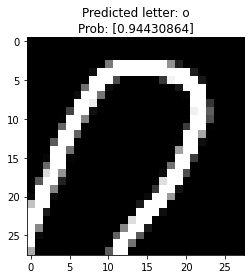

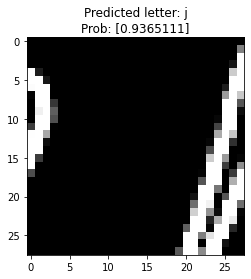

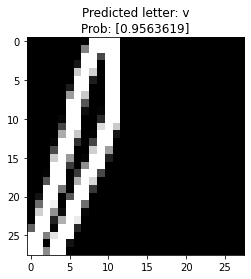

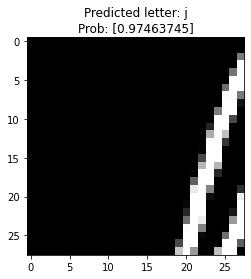

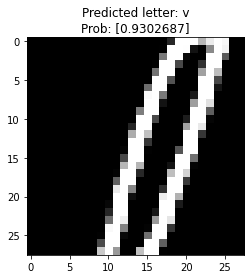

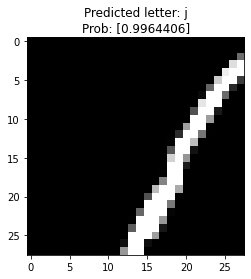

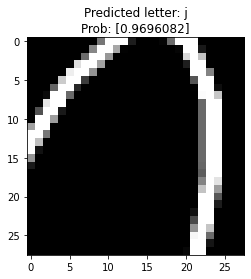

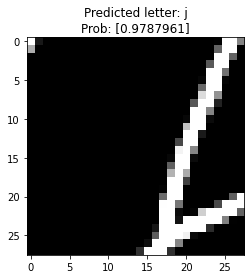

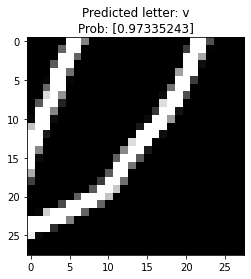

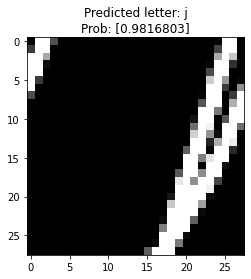

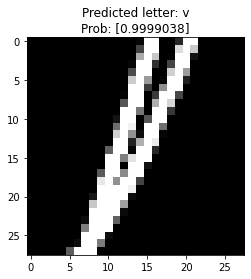

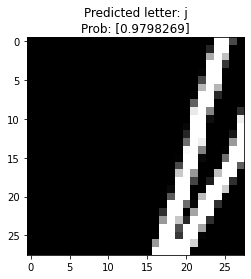

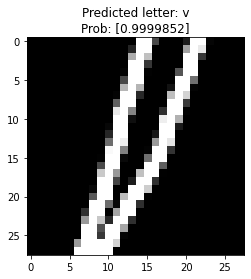

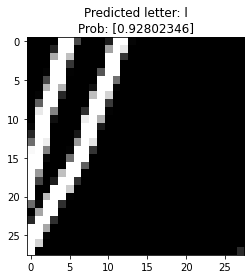

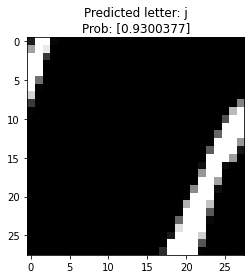

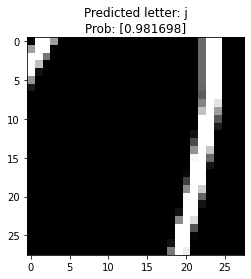

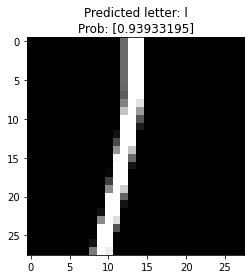

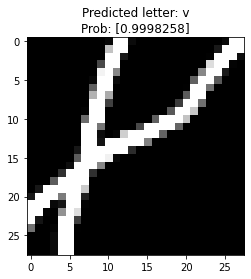

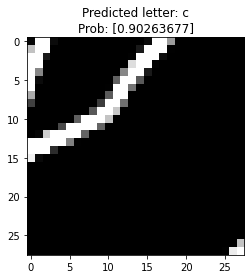

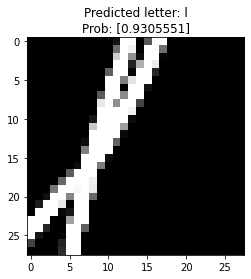

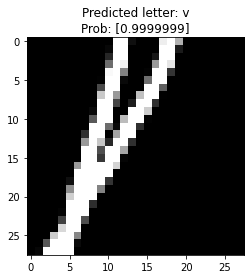

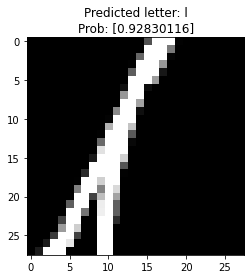

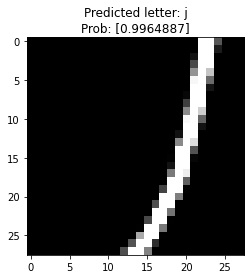

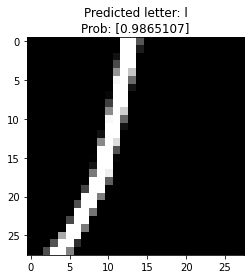

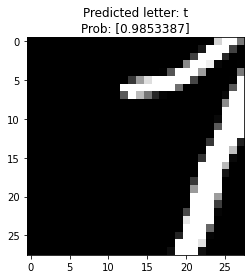

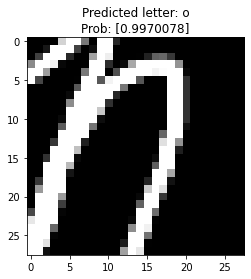

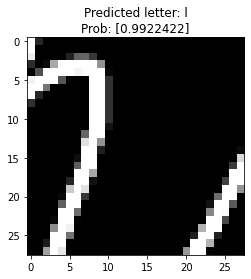

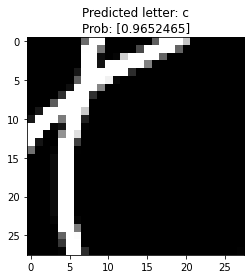

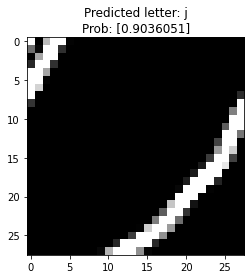

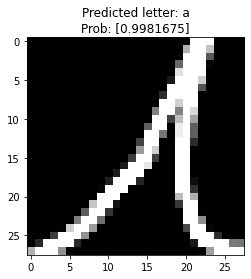

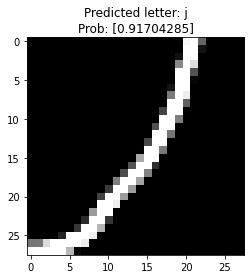

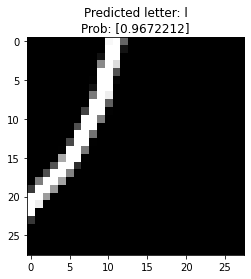

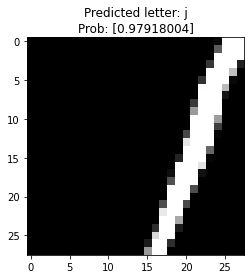

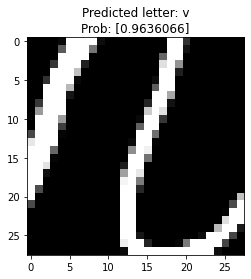

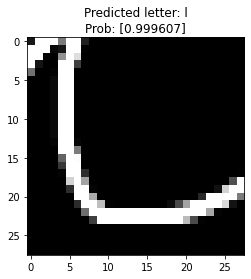

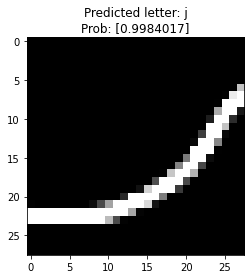

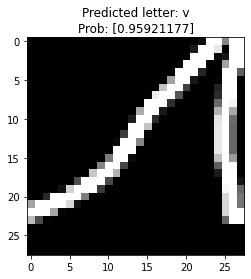

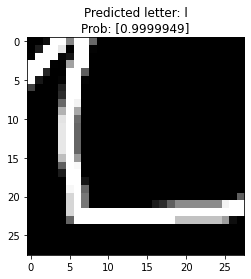

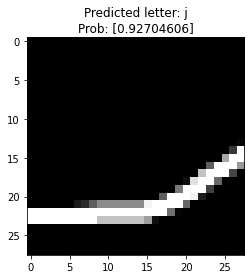

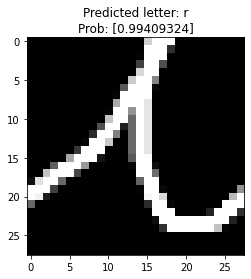

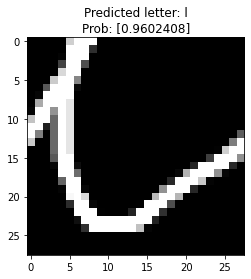

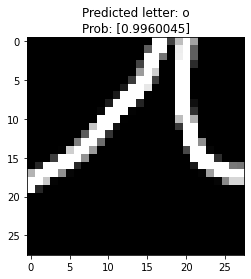

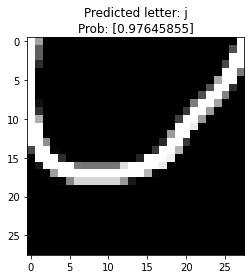

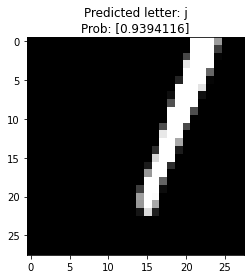

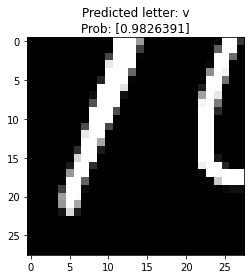

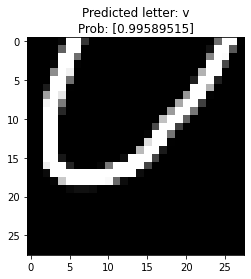

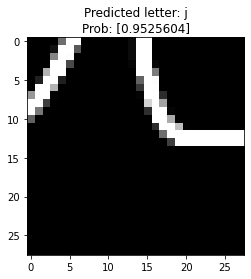

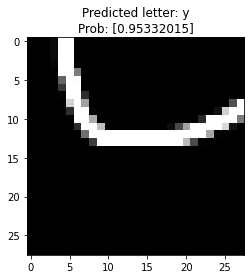

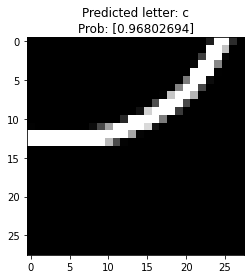

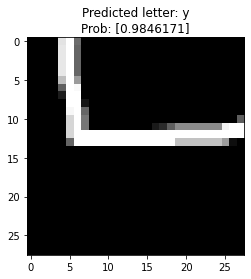

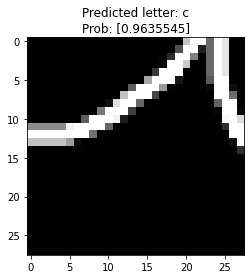

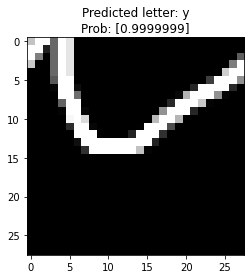

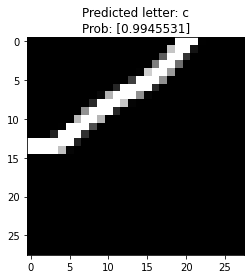

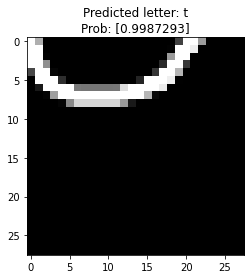

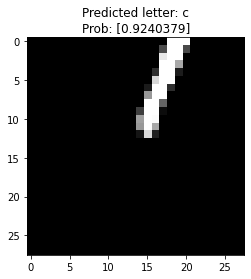

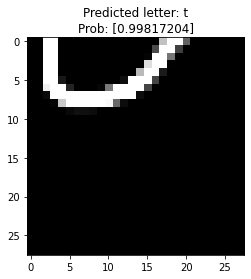

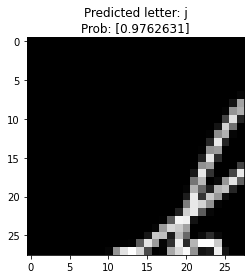

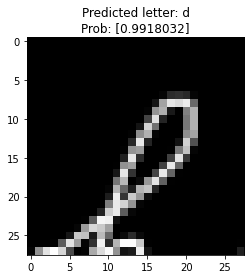

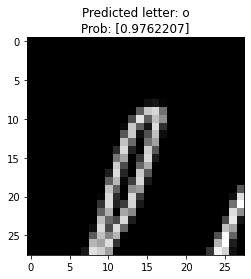

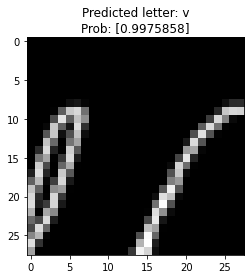

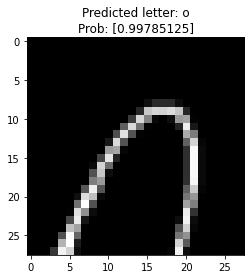

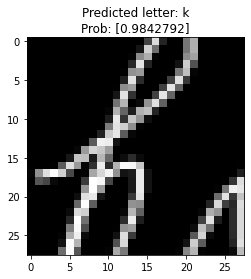

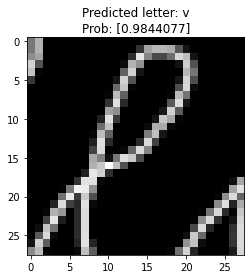

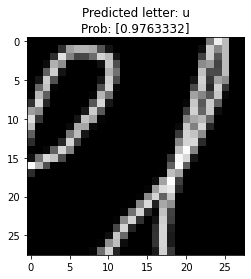

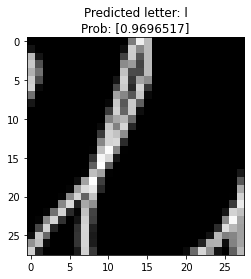

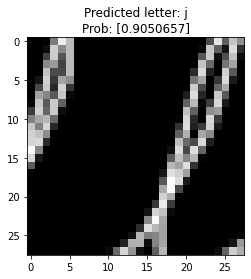

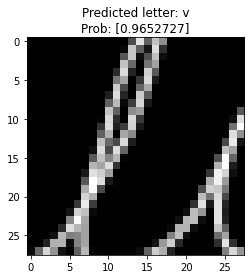

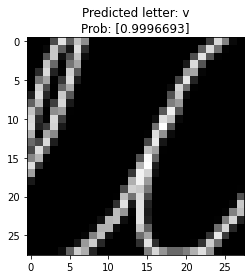

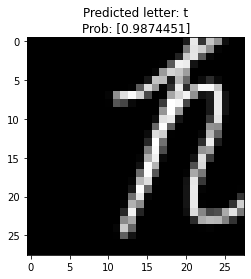

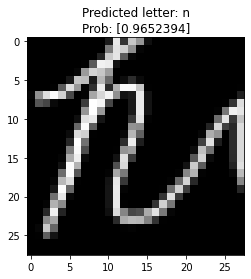

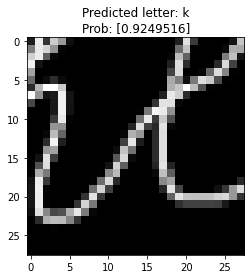

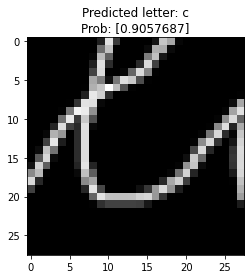

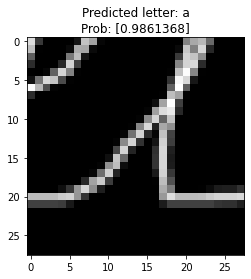

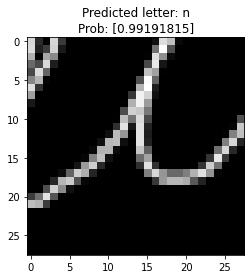

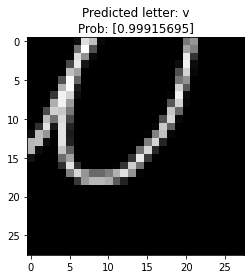

In [23]:
handwriting_detection(img, model, scale=2, stepSize=10, threshold=0.9)